In [4]:
import pandas as pd 
import spacy
from spacy import displacy
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
from pyvis.network import Network
from IPython.display import display, HTML
from utils import *

%config Completer.use_jedi = False

In [9]:
!python -m spacy download en_core_web_sm
NLP = spacy.load("en_core_web_sm")
NLP.max_length = 2500000

     --------------------------------------- 12.8/12.8 MB 12.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Preprocess books


In [5]:
src_dir = 'data'
dst_dir = 'data_preprocessed'
books = os.listdir('data')
for book in books:
    remove_empty_lines(f'{src_dir}/{book}', f'{dst_dir}/{book}')

## Load Books

In [7]:
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
all_books

[<DirEntry '1 The Way of Kings.txt'>,
 <DirEntry '2 Words of Radiance.txt'>,
 <DirEntry '3 Oathbringer.txt'>,
 <DirEntry '4 Rhythm of War.txt'>]

In [10]:
book = all_books[0]
book_text = open(book).read()
book_doc = NLP(book_text)

In [11]:
#Visualize identified entities
displacy.render(book_doc[0:600], style="ent", jupyter=True)

## Load character names

In [6]:
character_df = pd.read_csv('witcher_characters_final.csv', sep=';')
character_df.head(20)

,character,character_main_name,character_second_name,character_third_name,character_fourth_name
0,Aarhenius Krantz,Aarhenius,NaN,NaN,NaN
1,Abdank,Abdank,NaN,NaN,NaN
2,Abergard,Abergard,NaN,NaN,NaN
3,Abner de Navarette,Abner,NaN,NaN,NaN
4,Abonde,Abonde,NaN,NaN,NaN
5,"Abrad ""Jack-up-the-Skirt""",Abrad,NaN,NaN,NaN
6,Abrad the Old Oak,Abrad,NaN,NaN,NaN
7,Adalia,Adalia,NaN,NaN,NaN
8,Adam Pangratt,Adam,NaN,NaN,NaN
9,Adda of Temeria,Adda,NaN,NaN,NaN


## Get named entity list per sentence

In [7]:
sent_entity_df = []

for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({'sentence': sent, 'entities': entity_list})

sent_entity_df = pd.DataFrame(sent_entity_df)
sent_entity_df.head(30)

,sentence,entities
0,"(﻿'Does, she, always, devour, her, victims, ?, ')",[]
1,"(\n\n, Velerad, spat, vehemently, on, the, str...",[Velerad]
2,"(\n\n, ', Come, on, ,, Geralt, ,, it, 'll, be,...",[Geralt]
3,"(Pish, !)",[]
4,"(Devours, ,, takes, a, bite, ,, leaves, aside,...",[]
5,"(She, only, bit, the, head, from, one, ,, gutt...",[]
6,"(Damned, mother's-, !, ')",[]
7,"(\n\n, ', Careful, ,, Velerad, ,, ', snarled, ...","[Velerad, Ostrit]"
8,"(', Say, what, you, want, about, the, striga, ...",[Adda]
9,"(\n\n, ', Has, anyone, she, 's, attacked, surv...",[]


In [8]:
def filter_entity(ent_list, character_df):
    mask_df = character_df.isin(ent_list)
    mask_df = mask_df[mask_df.any(axis=1)]
    filtered_df  = character_df[character_df.index.isin(mask_df.index)]

    return list(filtered_df['character_main_name'])

In [9]:
test_filter = filter_entity(['Two', 'Emhyr', 'Witcher', 'Potato'], character_df)
test_filter

['Emhyr', 'Geralt']

In [10]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]

sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
1,"(\n\n, Velerad, spat, vehemently, on, the, str...",[Velerad],[Velerad]
2,"(\n\n, ', Come, on, ,, Geralt, ,, it, 'll, be,...",[Geralt],[Geralt]
7,"(\n\n, ', Careful, ,, Velerad, ,, ', snarled, ...","[Velerad, Ostrit]","[Ostrit, Velerad]"
8,"(', Say, what, you, want, about, the, striga, ...",[Adda],"[Adda, Adda]"
11,"(\n\n, Segelin, and, Ostrit, looked, at, each,...","[Segelin, Ostrit]","[Ostrit, Segelin]"
14,"(One, escaped-, ', \n\n, And, then, ,, ', inte...","[One, Velerad]",[Velerad]
23,"(\n\n, Having, finished, his, examination, Ger...",[Geralt],[Geralt]
25,"(It, was, Foltest, himself, .)",[Foltest],[Foltest]
59,"(\n\n, Yes, ,, ', Foltest, bristled, .)",[Foltest],[Foltest]
70,"(Geralt, grimaced, .)",[Geralt],[Geralt]


In [11]:
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])
sent_entity_df_filtered.head(10)

C:\Users\The God of Cringe\AppData\Local\Temp\ipykernel_15000\1739552770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])


,sentence,entities,character_entities
1,"(\n\n, Velerad, spat, vehemently, on, the, str...",[Velerad],[Velerad]
2,"(\n\n, ', Come, on, ,, Geralt, ,, it, 'll, be,...",[Geralt],[Geralt]
7,"(\n\n, ', Careful, ,, Velerad, ,, ', snarled, ...","[Velerad, Ostrit]","[Ostrit, Velerad]"
8,"(', Say, what, you, want, about, the, striga, ...",[Adda],"[Adda, Adda]"
11,"(\n\n, Segelin, and, Ostrit, looked, at, each,...","[Segelin, Ostrit]","[Ostrit, Segelin]"
14,"(One, escaped-, ', \n\n, And, then, ,, ', inte...","[One, Velerad]",[Velerad]
23,"(\n\n, Having, finished, his, examination, Ger...",[Geralt],[Geralt]
25,"(It, was, Foltest, himself, .)",[Foltest],[Foltest]
59,"(\n\n, Yes, ,, ', Foltest, bristled, .)",[Foltest],[Foltest]
70,"(Geralt, grimaced, .)",[Geralt],[Geralt]


## Create relationships

In [12]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])

    # Remove duplicated characters
    char_unique = [char_list[i] for i in range(len(char_list)) if i==0 or char_list[i] != char_list[i-1]]

    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({'source': a, 'target': b})

relationships_df = pd.DataFrame(relationships)

relationships_df.head(10)

,source,target
0,Velerad,Geralt
1,Velerad,Geralt
2,Geralt,Ostrit
3,Ostrit,Velerad
4,Ostrit,Velerad
5,Velerad,Adda
6,Ostrit,Velerad
7,Velerad,Adda
8,Ostrit,Velerad
9,Velerad,Adda


In [13]:
relationships_df = pd.DataFrame(np.sort(relationships_df.values, axis=1), columns=relationships_df.columns)
relationships_df['value'] = 1
relationships_df = relationships_df.groupby(['source', 'target'], sort=False, as_index=False).sum()
relationships_df.head(10)

,source,target,value
0,Geralt,Velerad,8
1,Geralt,Ostrit,16
2,Ostrit,Velerad,6
3,Adda,Velerad,5
4,Adda,Ostrit,3
5,Ostrit,Segelin,6
6,Segelin,Velerad,9
7,Foltest,Geralt,9
8,Adda,Foltest,4
9,Foltest,Velerad,6


## Graph analysis and visualization

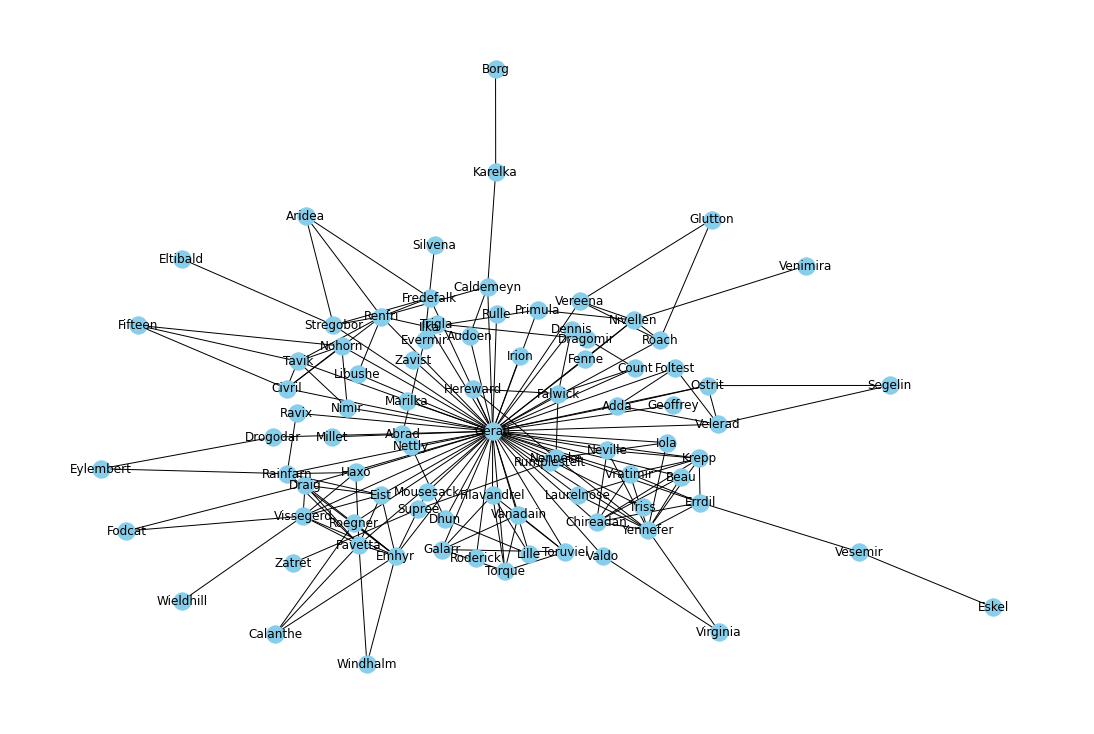

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(relationships_df, source='source', target='target', edge_attr='value', create_using=nx.Graph())

plt.figure(figsize=(15,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

### Graph visualization - Pyvis

In [15]:
from pyvis.network import Network
from IPython.display import display, HTML
net = Network(notebook = True, width='1000px', height='700px', bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

nx.set_node_attributes(G, node_degree, 'size')
net.from_nx(G)
net.show('graphs/witcher.html')

### The most important characters in The Witcher

<AxesSubplot:>

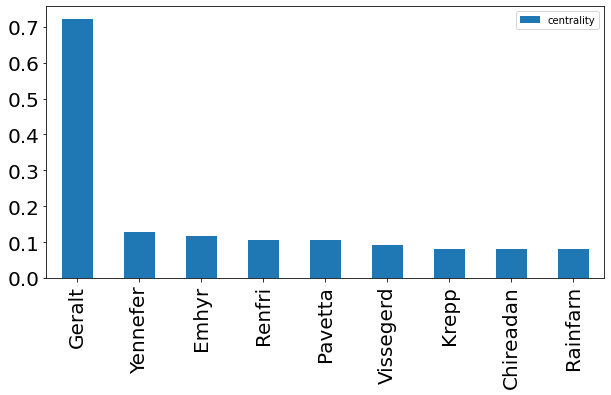

In [16]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar', figsize=(10,5), fontsize = 20)

<AxesSubplot:>

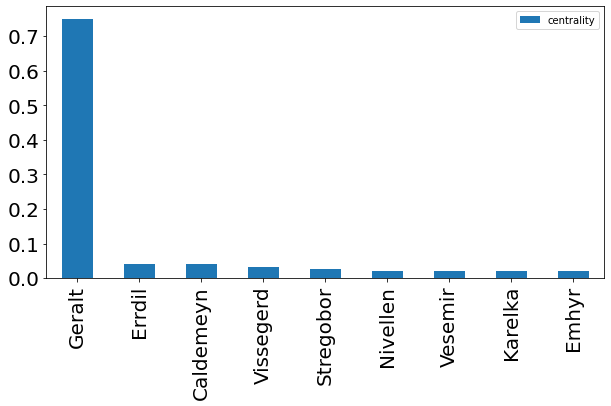

In [17]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar', figsize=(10,5), fontsize = 20)

<AxesSubplot:>

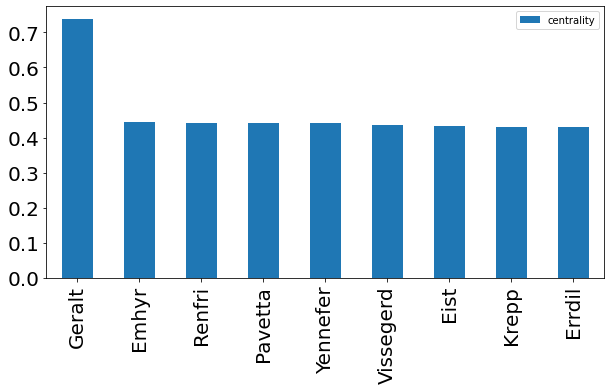

In [18]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar', figsize=(10,5), fontsize = 20)

In [19]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

### Community detection

In [20]:
import community as community_louvain

communities = community_louvain.best_partition(G)

nx.set_node_attributes(G, communities, 'group')
node_degree = dict(G.degree)

com_net = Network(notebook = True, width='1000px', height='700px', bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show('graphs/witcher_communities.html')

# Evolution of characters' importance

In [21]:
from utils import *

# Initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir('data') if '.txt' in b.name]
# Load spacy English languague model
nlp = spacy.load("en_core_web_sm")

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)

# Loop through book list and create graphs
for book in all_books:
    book_text = ner(book)
    
    # Get list of entities per sentences
    sent_entity_df = get_ne_list_per_sentence(book_text)
    
    # Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    # Take only first name of characters
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

    # Create relationship df
    relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
    relationship_df.to_csv(f'relationship_data/{book.name.split(".txt")[0]}.csv', index=False)
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    books_graph.append(G) 

C:\Users\The God of Cringe\AppData\Local\Temp\ipykernel_15000\3285166666.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
C:\Users\The God of Cringe\AppData\Local\Temp\ipykernel_15000\3285166666.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
C:\Use

<AxesSubplot:>

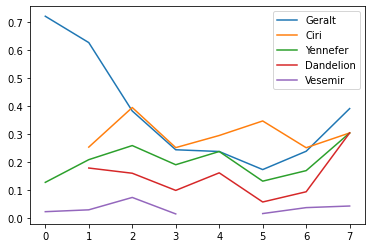

In [22]:
# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of 5 main characters
degree_evol_df[["Geralt", "Ciri", "Yennefer", "Dandelion", "Vesemir"]].plot()

In [23]:
for i, G in enumerate(books_graph):
    communities = community_louvain.best_partition(G)

    nx.set_node_attributes(G, communities, 'group')
    nx.set_node_attributes(G, node_degree, 'size')

    com_net = Network(notebook = True, width='1400px', height='800px', bgcolor='#222222', font_color='white')
    com_net.from_nx(G)
    com_net.show(f'graphs/witcher_{i}.html')

## Merge relationships from all books

In [6]:
import pandas as pd
import os
import glob

path = 'relationship_data'
csv_files = glob.glob(os.path.join(path, "*.csv"))

relationship_dfs = [pd.read_csv(f) for f in csv_files]

full_relationship_df = pd.concat(relationship_dfs, join='outer')
final_relationship_df = full_relationship_df.groupby(['source', 'target'], as_index=False)['value'].sum()
final_relationship_df.sort_values(by=['value'], inplace=True, ascending=False)
final_relationship_df.to_csv('relationship_data/final_witcher_relationships.csv', index=None)

print(final_relationship_df.head(30))


            source      target  value
431           Ciri    Yennefer   1099
1078        Geralt    Yennefer    885
359           Ciri      Geralt    861
552      Dandelion      Geralt    478
1515         Triss    Yennefer    385
373           Ciri      Kelpie    361
416           Ciri       Triss    351
237          Cahir      Geralt    304
241          Cahir       Milva    301
1012        Geralt       Milva    287
1056        Geralt       Triss    235
1526    Vilgefortz    Yennefer    227
1083        Geralt      Zoltan    176
479   Condwiramurs       Nimue    165
764           Essi      Geralt    151
423           Ciri  Vilgefortz    147
368           Ciri       Jarre    142
349           Ciri       Fabio    134
939      Fringilla      Geralt    134
1331         Milva      Zoltan    131
731          Emhyr     Vattier    129
916      Francesca    Yennefer    128
426           Ciri    Vysogota    125
1428      Philippa    Yennefer    125
230          Cahir        Ciri    123
343         

### Visualize witcher relationships from all books

In [13]:
final_relationship_df = pd.read_csv('relationship_data/final_witcher_relationships.csv', index_col=False)
final_relationship_df = final_relationship_df.loc[:, ~final_relationship_df.columns.str.contains('^Unnamed')]
final_relationship_df = final_relationship_df[final_relationship_df['value']>5]
final_relationship_df

,source,target,value
0,Ciri,Yennefer,1099
1,Geralt,Yennefer,885
2,Ciri,Geralt,861
3,Dandelion,Geralt,478
4,Triss,Yennefer,385
...,...,...,...
847,Adam,Barclay,6
848,Ervyll,Junghans,6
849,Aen,Auberon,6
850,Agnes,Aurora,6


In [11]:
G = nx.from_pandas_edgelist(final_relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())    

node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

com_net = Network(notebook = True, width='1920px', height='1080px', bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show(f'graphs/final_witcher_relationships.html')

In [15]:
G = nx.from_pandas_edgelist(final_relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())    

communities = community_louvain.best_partition(G)
node_degree = dict(G.degree)

nx.set_node_attributes(G, communities, 'group')
nx.set_node_attributes(G, node_degree, 'size')

com_net = Network(notebook = True, width='100%', height='1080px', bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show_buttons(filter_=['physics'])
com_net.show(f'graphs/final_witcher_relationships_grouped_5th.html')